In [139]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

#sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from utils import utils
import matplotlib.patches as mpatches 

import warnings

warnings.filterwarnings("ignore")

### Download data and seperate to train and test sets

In [ ]:
#get data and visualize them
# df = utils.get_data_yf('SPY', start = "2019-01-01").reset_index()
ticker = yf.Ticker('SPY')
df = ticker.history(interval = '1h', period = '1y')

# # Filter data to regular trading hours
# start_time = pd.Timestamp('9:30').time()
# end_time = pd.Timestamp('16:00').time()
# df = df.between_time(start_time, end_time)

#rename the index and reset it
df = df.rename_axis("Date").reset_index()

# #date of seperation
date_sep = datetime(2022, 8, 1, 0, 0, 0)
date_sep = pd.Timestamp(date_sep).tz_localize('America/New_York')

# #train data
train_data = df[df['Date'] < date_sep]
test_data = df[df['Date'] >= date_sep]

[*********************100%***********************]  1 of 1 completed


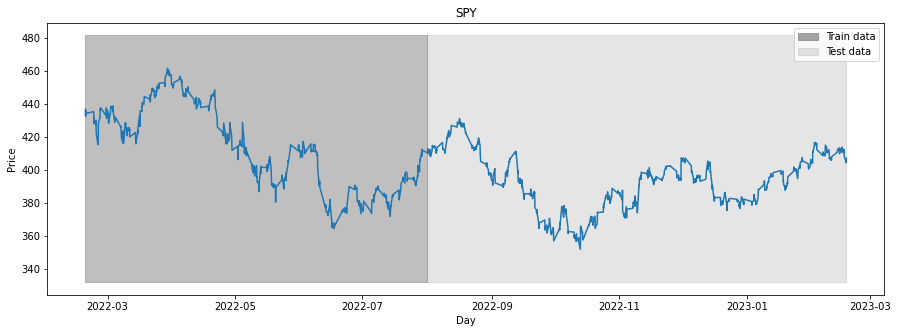

In [129]:
#plot the results
fig, ax = plt.subplots(figsize = (15, 5))

x = df['Date']
y = df['Close']

ax.plot(x, y)
ax.fill_between([df['Date'][0], date_sep], [df['Close'].min()-20], [df['Close'].max()+20], color = 'grey', alpha = 0.5)
ax.fill_between([date_sep, df['Date'][len(df) - 1]], [df['Close'].min()-20], [df['Close'].max()+20], color = 'grey', alpha = 0.2)
plt.title('SPY')
plt.xlabel('Day')
plt.ylabel('Price')
dark_grey = mpatches.Patch(color = 'grey', alpha = 0.7, label = 'Train data')
light_grey = mpatches.Patch(color = 'grey', alpha = 0.2, label = 'Test data')
plt.legend(handles = [dark_grey, light_grey])
plt.show()

### Transforming data

In [130]:
def transform_data(data):
        
    data['volume_diff'] = data['Volume'].diff()
    data['normalized_value'] = data.apply(lambda x: utils.normalized_values(x.High, x.Low, x.Close), axis = 1)
    data['lr2'] = data['Close'].rolling(2).apply(lambda x: stats.linregress(x.index, x)[0])
    data['lr3'] = data['Close'].rolling(3).apply(lambda x: stats.linregress(x.index, x)[0])
    data['lr4'] = data['Close'].rolling(4).apply(lambda x: stats.linregress(x.index, x)[0])
    data['lr5'] = data['Close'].rolling(5).apply(lambda x: stats.linregress(x.index, x)[0])
    
    return data

#transform data
train_df = transform_data(train_data)

### Performing PCA 

In [131]:
#interested_columns
int_cols = ['volume_diff', 'normalized_value', 'lr2', 'lr3', 'lr4', 'lr5']

X = train_df[int_cols].dropna(axis = 0)
original_index = X.index

#scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components = 2).fit(X_scaled)
X_pca = pca.fit_transform(X_scaled)

#add data back to the original dataframe
train_df['pc1'], train_df['pc2'] = np.nan, np.nan
train_df.loc[original_index, 'pc1'] = X_pca[:, 0]
train_df.loc[original_index, 'pc2'] = X_pca[:, 1]

### Plot the principal components

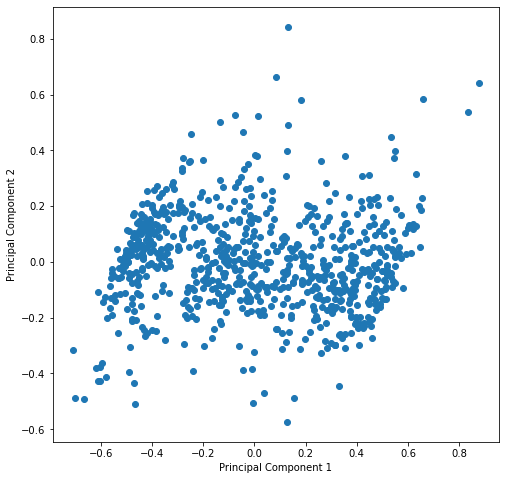

In [132]:
plt.figure(figsize = (8, 8))
plt.scatter(train_df['pc1'], train_df['pc2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Outlier Analysis

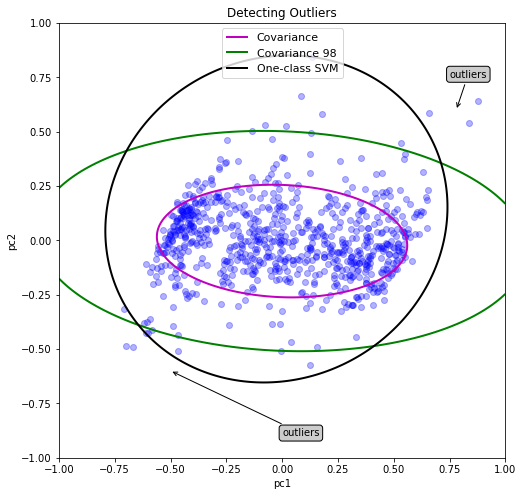

In [178]:
#define all the classifiers using for the analysis
classifiers = {
    "Covariance": EllipticEnvelope(support_fraction = 1.0, contamination = 0.25),
    "Covariance 98": EllipticEnvelope(support_fraction = 1.0, contamination = 0.02),
    "One-class SVM": OneClassSVM(nu = 0.01, gamma = 0.1)
}

colors = ["m", "g", "k"]
legend1 = {}
legend2 = {}

#create a plot that shows outliers
xx1, yy1 = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1, figsize = (8, 8))
    clf.fit(train_df[['pc1', 'pc2']].dropna(axis = 0))
    z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    z1 = z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(xx1, yy1, z1, levels = [0], linewidths = 2, colors = colors[i])
    
legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

#plot the results
plt.figure(1, figsize = (8, 8))
plt.title("Detecting Outliers")
plt.scatter(train_df['pc1'], train_df['pc2'], color = 'b', alpha = 0.3)
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outliers",
    xy=(-0.5, -0.6),
    xycoords="data",
    textcoords="data",
    xytext=(0, -0.9),
    bbox=bbox_args,
    arrowprops=arrow_args,
)

plt.annotate(
    "outliers",
    xy=(0.78, 0.6),
    xycoords="data",
    textcoords="data",
    xytext=(0.75, 0.75),
    bbox=bbox_args,
    arrowprops=arrow_args,
)


plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend(
    (
        legend1_values_list[0].collections[0],
        legend1_values_list[1].collections[0],
        legend1_values_list[2].collections[0],
    ),
    (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("pc2")
plt.xlabel("pc1")

plt.show()

### Using EllipticEnvelope to find outliers

In [204]:
#get data
X = train_df[['pc1', 'pc2']].dropna(axis = 0)
original_index = X.index

#initiate model
# en = EllipticEnvelope(support_fraction = 1.0, contamination = 0.01)
en = OneClassSVM(nu = 0.01, gamma = 0.2)

#fit model
en.fit(X)
outliers = en.predict(X)

#append to the original dataframe
train_df.loc[original_index, 'outlier'] = outliers

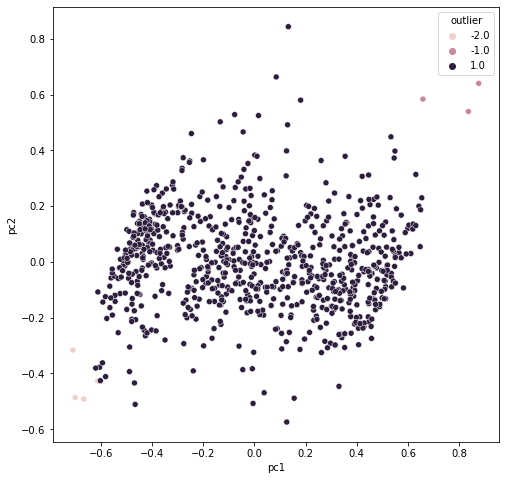

In [205]:
#seperate outliers into two pc2 > 0 and pc2 < 0
train_df['outlier'] = [-2 if (x < 0) and (y == -1) else y for (x, y) in zip(train_df.pc2, train_df.outlier)]

#create a scatter plot to identify outliers in the scatter plot
plt.figure(figsize = (8, 8))
sns.scatterplot(x = 'pc1', y = 'pc2', data = train_df, hue = 'outlier')
plt.show()

### Plot the outliers in the timeseries plot

In [206]:
train_df['buy_signal'] = [z if (y == -2) else np.nan for (y, z) in zip(train_df.outlier, train_df.Close)]
train_df['sell_signal'] = [z if (y == -1) else np.nan for (y, z) in zip(train_df.outlier, train_df.Close)]

<AxesSubplot:xlabel='Date', ylabel='Close'>

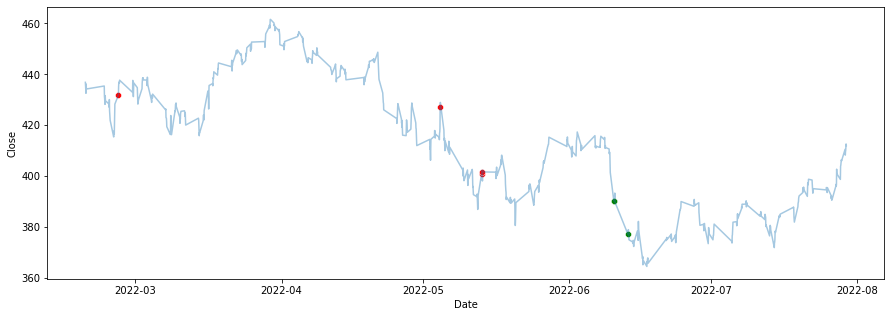

In [207]:
#plot the datapoints
plt.figure(figsize = (15, 5))
sns.lineplot(x = 'Date', y = 'Close', data = train_df, alpha = 0.4)
sns.scatterplot(x = 'Date', y = 'buy_signal', data = train_df, color = 'r')
sns.scatterplot(x = 'Date', y = 'sell_signal', data = train_df, color = 'g')